# NYC Middle School Analysis
## 1. Introduction
Within the New York City school system are nine highly selective public high schools established and administered by the NYC Department of Education to serve the needs of academically and artistically gifted students. These schools are, in order of establishment date:

1. Stuyvesant High School
2. Brooklyn Technical High School
3. The Bronx High School of Science
4. Staten Island Technical High School
5. Fiorello H. LaGuardia High School of Music & Art and Performing Arts
6. High School for Math, Science and Engineering at City College
7. High School of American Studies at Lehman College
8. Queens High School for the Sciences at York College
9. Brooklyn Latin School

Admissions to eight of the nine schools is contingent on scoring highly on the Specialized High School Admissions Test (SHSAT). LaGuardia High School, the one for which the SHSAT is not needed, requires a portfolio and audition for admission. With the recent discussions going on in the NYC about the future of the specialized high schools, and espeically about the admissions process, I wanted to take a look at the factors that lead to admissions to these prestigious schools.  

## 2. The Dataset
The dataset comes from the NYC DOE, and contains data from all 594 NYC middle schools (485 public and 109 charter).

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy import stats

data = pd.read_csv('../data/middleSchoolData.csv')
data.sample(5)

,dbn,school_name,applications,acceptances,per_pupil_spending,avg_class_size,asian_percent,black_percent,hispanic_percent,multiple_percent,...,effective_school_leadership,strong_family_community_ties,trust,disability_percent,poverty_percent,ESL_percent,school_size,student_achievement,reading_scores_exceed,math_scores_exceed
380,25Q281,EAST-WEST SCHOOL OF INTERNATIONAL STUDIES,70,20,16753.0,27.96,67.3,8.3,18.8,0.9,...,2.37,3.30,3.07,13.3,86.3,6.0,649.0,4.13,0.75,0.78
178,10X390,M.S. 390,24,1,23289.0,19.66,0.6,12.8,86.5,0.0,...,3.91,4.28,3.87,25.0,98.1,29.7,539.0,3.97,0.29,0.20
584,84X491,ACADEMIC LEADERSHIP CHARTER SCHOOL,32,2,NaN,NaN,0.2,46.1,51.5,1.1,...,3.40,3.05,2.98,9.8,90.2,11.8,549.0,NaN,0.34,0.25
362,24Q093,I.S. 093 RIDGEWOOD,78,2,17462.0,22.58,9.2,1.9,71.2,0.5,...,3.62,3.45,3.99,21.7,94.7,15.3,1099.0,3.24,0.46,0.40
476,32K162,J.H.S. 162 THE WILLOUGHBY,8,0,22791.0,21.00,3.3,5.6,87.5,0.8,...,3.71,3.72,4.06,23.9,90.3,18.1,360.0,3.49,0.35,0.33


## 3. Applications and Acceptances

First I took a look at the correlation between the number of applications and the number of admissions to a specialized high school. For this I calculated the Pearson correlation coefficient, which is 0.8017. This is a fairly high correlation coefficient, suggesting that there is a strong positive correlation between the number of applications and the number of acceptances.

(0.8017265370719302, 1.9292582453106036e-134)


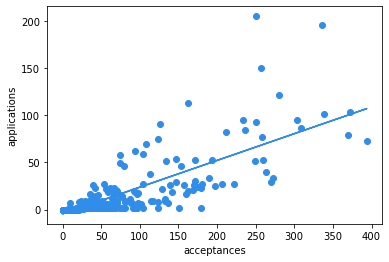

In [2]:
applications = data['applications']
acceptances = data['acceptances']
print(stats.pearsonr(applications, acceptances))

m, b = np.polyfit(applications, acceptances, 1)
plt.xlabel('acceptances')
plt.ylabel('applications')
plt.scatter(applications, acceptances, color = '#318DEA')
plt.plot(applications, m * applications + b, color = '#318DEA')

I also thought that the application rate, that is the  number of applications in relation to the size of the school, might've been a better predictor for number of admissions. This turned out to not be the case since the Pearson correlation coefficient, 0.6588, was lower than the one calculated for raw number of applications. Therefore the correlation between the application rate and number of acceptances is not as strong.

(0.6587507529002679, 6.141061848418876e-75)


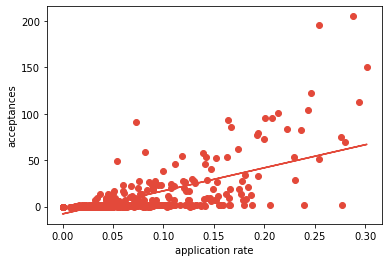

In [3]:
acceptances = data['acceptances']
school_size = data['school_size']
applications = data['applications']

application_rate = []
for i in range(len(school_size)):
    if not math.isnan(school_size[i]):
        application_rate.append(applications[i] / school_size[i])
    else:
        acceptances = acceptances.drop(i)
print(stats.pearsonr(application_rate, acceptances))

application_rate = pd.Series(application_rate)
m, b = np.polyfit(application_rate, acceptances, 1)
plt.xlabel('application rate')
plt.ylabel('acceptances')
plt.scatter(application_rate, acceptances, color = '#E3493A')
plt.plot(application_rate, m * application_rate + b, color = '#E3493A')

## 4. Wealth and Admissions

One topic that has been subject of debate is the role that a family's wealth plays in specialized high school admissions. Ideally, the SHSAT provides a standardized way to assess a prospective student's academic abilities since every student takes the same test during the same time of year. However, it has been argued that wealthier families are more able access tutoring services and other resources that could give their child an upper hand in admissions. To test the merit of this argument, I wanted to run a statistical hypothesis test.

My null hypothesis is that there is no difference between the acceptance rates of schools with higher poverty percentages and the acceptance rates of schools with lower poverty percentages. The alternative hypothesis would be that there is a difference between the acceptance rates of the two groups. 

First, I found the acceptance rate for each school by dividing the number of acceptances by the number of applications. Schools that had no applications had their acceptance rate set as 0. I then found the median poverty percentage to be 82.85%, and split the list of acceptance rates into two groups based on if the school’s poverty percentage was above or below the median. I conducted an independent samples t-test and found a t-statistic of 8.9145 and a p-value of 6.09 x 10<sup>-18</sup>. Since the p-value less than 0.05, I can reject the null hypothesis and have evidence to suggest that there is a difference in the acceptance rates between schools with higher poverty rates and schools with lower poverty rates.

Ttest_indResult(statistic=-8.914562087983786, pvalue=6.0895309011999434e-18)


(0.03713709542874199, 0.12418087019954589)

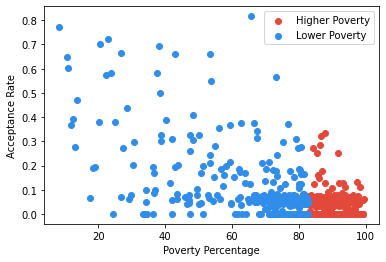

In [4]:
subdata = data[["school_name", "applications", "acceptances", "poverty_percent"]]
subdata = subdata.dropna()

applications, acceptances, poverty_percent, acceptance_rate = [], [], [], []

for row in subdata.values: 
    applications.append(row[1])
    acceptances.append(row[2])
    poverty_percent.append(row[3])
for i in range(len(applications)):
        acceptance_rate.append(acceptances[i] / applications[i]) if applications[i] != 0 else acceptance_rate.append(0)

median = np.median(poverty_percent)
below, above, below_rate, above_rate = [], [], [], []
for i in range(len(poverty_percent)):
    if poverty_percent[i] < median:
        above.append(acceptance_rate[i])
        above_rate.append(poverty_percent[i])
    else:
        below.append(acceptance_rate[i])
        below_rate.append(poverty_percent[i])
print(stats.ttest_ind(below, above))

plt.scatter(below_rate, below, color = "#E3493A", label = "Higher Poverty")
plt.scatter(above_rate, above, color = "#318DEA", label = "Lower Poverty")
plt.ylabel("Acceptance Rate")
plt.xlabel("Poverty Percentage")
plt.legend(loc = "upper right")
(np.mean(below), np.mean(above))

It has also been argued that students who attend schools in wealthier neighborhoods are given an unfair advantage since these schools are able to secure more funding, and are therefore able to provide more high-quality resources for their students to excel. I decided to see if the availability of material resources impacted objective measures of achievement or admissions to a specialized high school.

I first conducted a Princpal Component Analysis (PCA) for dimension reduction, and used the Kaiser criterion for determining the number of independent factors. It turns out that both the measures of the availability of material resources and the measures of achievement/admissions could be reduced down to one independent factor each. I then calculated a Pearson correlation coefficient of -0.6099. This suggests that there is a mild negative correlation between the availability of resources and student achievement, which goes against the claims that have been made regarding the impact of material resources. 

But there are many possible explanations for this behavior. One could be that schools that have higher percentages of students with disabilitiesa also tend to have higher per student spending, as they need the additional resources to accommodate their student body. However, students with disabilities also have lower rates of being admitted to a specialized high school and generally perform worse academically compared to their peers, which might explain why we see a negative correlation. 

To test this idea, I found the partial correlation between the availability of resources and achievement while controlling for the percent of students with disabilities and it turned out to be -0.3663, which is much weaker than before. There could be other variables at play here that contribute to the negative relationship, so I believe that a multiple regression model would be useful.

(-0.6098863596116151, 3.3367000121407144e-48)


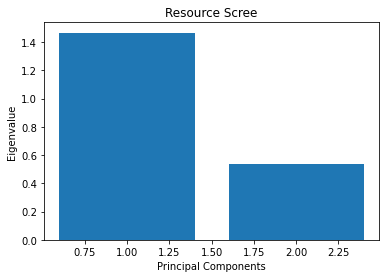

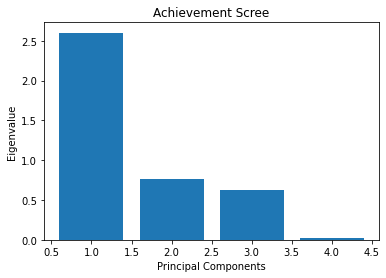

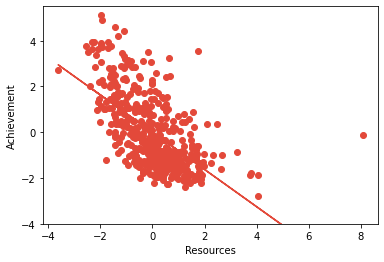

In [5]:
from sklearn.decomposition import PCA

subdata = data[["per_pupil_spending", "avg_class_size", "acceptances", "applications", 
                "student_achievement", "reading_scores_exceed", "math_scores_exceed"]]
subdata = subdata.dropna()

resources, achievement = [], []
for row in subdata.values:
    resources.append(row[:2])
    achievement.append(row[3:7])
    
zscored_resources = stats.zscore(resources)
zscored_achievement = stats.zscore(achievement)

pca1 = PCA()
pca1.fit(zscored_resources)
eig_val1 = pca1.explained_variance_
loadings1 = pca1.components_
rotated_data1 = pca1.fit_transform(zscored_resources)
covar_explained1 = eig_val1 / sum(eig_val1) * 100

pca2 = PCA()
pca2.fit(zscored_achievement)
eig_val2 = pca2.explained_variance_
loadings2 = pca2.explained_variance_
rotated_data2 = pca2.fit_transform(zscored_achievement)
covar_explained2 = eig_val2 / sum(eig_val2) * 100

print(stats.pearsonr(rotated_data1[:,0], rotated_data2[:,0]))

num_classes = len(eig_val1)
plt.bar(np.linspace(1, num_classes, num_classes), eig_val1)
plt.title("Resource Scree")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalue")
plt.show()

plt.bar(np.linspace(1, len(eig_val2), len(eig_val2)), eig_val2)
plt.title("Achievement Scree")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalue")
plt.show()

m, b = np.polyfit(rotated_data1[:,0], rotated_data2[:,0], 1)

plt.scatter(rotated_data1[:,0], rotated_data2[:,0], color = "#E3493A")
axes = plt.gca()
axes.set_ylim([-4, 5.5])
plt.xlabel("Resources")
plt.ylabel("Achievement")
plt.plot(rotated_data1[:,0], rotated_data1[:,0] * m + b, color = "#E3493A")

## 5. Feeder Schools
Another frequently raised concern is the existence of feeder schools, which are schools where a disproportionately high number of students are admitted to specializaed high schools compared to other NYC middle schools. To see if feeder schools were actually a noticeable phenomena in the high schools admissions environment, I first found the schools with the best *per student* odds of sending a student to a specialized high school.

I defined odds as the probability of a school sending a student to a specialized high school divided by the probability that it doesn't. The probability of a school sending a student to a specialized high school is the number of acceptances divided by the school's total population. I then divided this by the probability of the school not sending someone to a specialized high school, which I found by subtracting the number from 1, in order to get the odds. 

The school that had the best *per student* odds was The Christa McAuliffe School, whose *per student* odds was 0.3069.

In [6]:
acceptances = data['acceptances']
school_size = data['school_size']

sending = []
for i in range(len(acceptances)):
    if not math.isnan(school_size[i]):
        sending.append(acceptances[i] / school_size[i])
    else:
        sending.append(0)
odds = [val / (1 - val) for val in sending]

school_odds = {data['school_name'][i] : odds[i] for i in range(len(odds))}
sorted(school_odds, key = school_odds.get, reverse = True)[0:10]

['THE CHRISTA MCAULIFFE SCHOOL\\I.S. 187',
 'NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORATIVE STUDIES',
 'M.S. 255 SALK SCHOOL OF SCIENCE',
 'J.H.S. 054 BOOKER T. WASHINGTON',
 'EAST SIDE MIDDLE SCHOOL',
 'MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED',
 'BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION',
 'THE ANDERSON SCHOOL',
 'M.S. 51 WILLIAM ALEXANDER',
 'THE MATH & SCIENCE EXPLORATORY SCHOOL']

I noticed that the schools in the list were all rated relatively highly by their students when it came to factors involving the school's climate. This includes things such as having collaborative teachers or a supportive environment, which can be found in columns L-Q of the dataset. This made me wonder if there was a relationship between a school's climate and how well its students performs on objective measures of achievement, such as the ELA and Mathematics test that students in New York State take between grades 3 and 8. This data can be found in columns V-X of the dataset.

To find the relationship between a school’s climate and how well it performs on objective measures of achievement, I first ran a PCA and reduced both of these variables to one independent factor each, and then found the Spearman correlation coefficient between a school’s climate and a school’s performance on measures of achievement to be -0.4222. This leads me to beleive that there is a negative relationship between the two variables, or that as the perception of a school improves, the school’s measure of achievement gets worse. Again, this doesn’t seem to make sense, so this could be an instance where there are  confounding variables and another reason why a multiple regression model would be useful. 

SpearmanrResult(correlation=-0.4450756774616421, pvalue=5.901098939679109e-27)


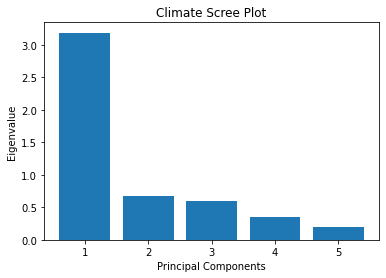

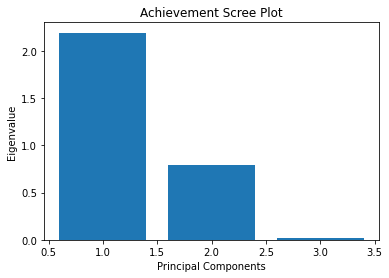

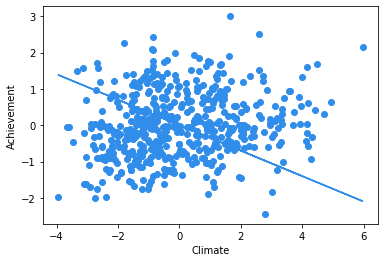

In [7]:
subdata = data[['rigorous_instruction', 'collaborative_teachers', 'supportive_environment',
                'effective_school_leadership', 'strong_family_community_ties', 'trust',
                'student_achievement', 'reading_scores_exceed', 'math_scores_exceed']]
subdata = subdata.dropna()

climate, achievement = [], []
for row in subdata.values:
    climate.append(row[:5])
    achievement.append(row[6:9])

zscored_climate = stats.zscore(climate)
zscored_achievement = stats.zscore(achievement)

pca1 = PCA()
pca1.fit(zscored_climate)
eig_val1 = pca1.explained_variance_
loadings1 = pca1.components_
rotated_data1 = pca1.fit_transform(zscored_climate)
covar_explained1 = eig_val1 / sum(eig_val1) * 100

pca2 = PCA()
pca2.fit(zscored_achievement)
eig_val2 = pca2.explained_variance_
loadings2 = pca2.explained_variance_
rotated_data2 = pca2.fit_transform(zscored_achievement)
covar_explained2 = eig_val2 / sum(eig_val2) * 100

print(stats.spearmanr(rotated_data1[:,0], rotated_data2[:,0]))

num_classes = len(eig_val1)
plt.bar(np.linspace(1, num_classes, num_classes), eig_val1)
plt.title("Climate Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalue")
plt.show()

plt.bar(np.linspace(1, len(eig_val2), len(eig_val2)), eig_val2)
plt.title("Achievement Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalue")
plt.show()

plt.scatter(rotated_data1[:,0], rotated_data2[:,1], color = "#318DEA")
plt.xlabel("Climate")
plt.ylabel("Achievement")
m, b = np.polyfit(rotated_data1[:,0], rotated_data2[:,0], 1)
plt.plot(rotated_data1[:,0], m * rotated_data1[:,0] + b, color = "#318DEA")

After calculating each school's *per student* odds of sending a student to a specialized high school, I noticed that there were many, many schools in the city that did not have a single student even submit an application to a specialized high school. This suggests that the vast majority of admitted students come from a small portion of NYC middle schools.  

I wanted to see what proportion of schools accounted for 90% of the acceptances to specialized high schools, or 4,014.9 out of 4,461. Starting from the school with the most acceptances, I added up the number of acceptances from each school until the sum passed 4,019.9. It turns out that of the 594 schools, the top 124 schools account for 90% of all students accepted into a specialized high school. 

Below is a bar graph of schools ordered from those having the least number of acceptances to those with the most. Underneath that cumulative distribution plot of acceptances. As we can see, the 124 schools on the right of the black line make up the vast majority of the acceptances while the remaining 470 make up only 10%. 

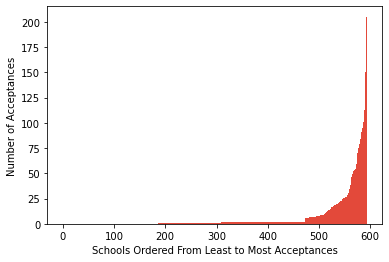

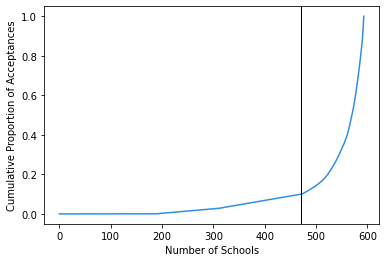

In [8]:
acceptances = data["acceptances"]
total_acceptances = acceptances.sum()
ninety = total_acceptances * 0.9

acceptances = sorted(acceptances)
total = 0
for i in range(len(acceptances)):
    total += acceptances[i]
    if total > ninety:
        top = i
        break

percentage = [acceptance / total_acceptances for acceptance in acceptances]
xlist = list(range(len(percentage)))

total_percent = 0
ylist = []
for i in range(len(percentage)):
    total_percent += percentage[i]
    ylist.append(total_percent)
    
plt.bar(xlist, acceptances, 1, color = "#E3493A")
plt.xlabel("Schools Ordered From Least to Most Acceptances")
plt.ylabel("Number of Acceptances")
plt.show()

plt.plot(xlist, ylist, color = "#318DEA")
plt.axvline(x = 470, color = "black", linewidth = 1)
plt.xlabel("Number of Schools")
plt.ylabel("Cumulative Proportion of Acceptances")
plt.show()

## 6. Modeling

As mentioned previously, I believe that a multiple regression model would be helpful to get a more clear picture of all the factors involved in specialized high school admissions. I created two multiple regression models based on the factors that we have examined so far. First, let's take a look at the factors that affect objective measures of achievement: 

$$ \text{Achievement} = 2.604 \times 10^{-16} + (1.093 \times 10^{-5})X_1 +  (0.2116)X_2 + (-6.902 \times 10^{-3})X_3 $$
       
In this model:
- X1 represents the availability of material resources
- X2 represents a school's climate based on student ratings
- X3 represents the percentage of students who are disadvantaged, whether it be because they come from poverty, are disabled, or have English as a second language. 

This model gives us pretty straightforward conclusions. As tje availability of material resources and better perception of the school increases the performance of students on objective measures of achievement, while an increase in the percentage of disadvantaged students lower the achievement. The most important factor to consider here it seems is the perception of the school, and the kind of climate students are placed in.

The first one predicts the number of admitted students there are at a given school: 

$$\text{Acceptances} = -3.515 + (0.2707)X_1 + (2.577 \times 10^{-4})X_2 + (-0.4325)X_3 + (0.2166)X_4$$         
Such that:
- X<sub>1</sub> represents the number of applications
- X<sub>2</sub> represents the availability of material resources
- X<sub>3</sub> represents a school's climate based on student ratings
- X<sub>4</sub> represents the percentage of students who are disadvantaged, whether it be because they come from poverty, are disabled, or have English as a second language. 

Based on the model above, the most important factor for determining the number of acceptances at a school is the number of applications coming from that school. Increasing the availability of material resources does also seem to increase the number of acceptances, although the effect is relatively small. Interestingly, a better perception of the school actually serves to decrease the number of acceptances that come from the school while an increased percentage of disadvantaged students increases the number of acceptances. This could potentially be due to the interaction between variables, but there could be a lot of other explanations for this behavior. 

In [9]:
subdata = data[["applications", "acceptances", "per_pupil_spending", "avg_class_size", "rigorous_instruction", "collaborative_teachers", 
                "supportive_environment", "effective_school_leadership", "strong_family_community_ties", "trust", "disability_percent", 
                "poverty_percent", "ESL_percent", "school_size", "student_achievement", "math_scores_exceed", "reading_scores_exceed"]]
subdata = subdata.dropna()

resources = subdata[["per_pupil_spending", "avg_class_size"]]
climate = subdata[["rigorous_instruction","collaborative_teachers", "supportive_environment", 
                   "effective_school_leadership", "strong_family_community_ties", "trust"]]
disadvantage = subdata[["disability_percent", "poverty_percent", "ESL_percent"]]
achievement = subdata[["student_achievement", "math_scores_exceed", "reading_scores_exceed"]]

resources_pca = PCA()
resources_pca.fit(resources)
rotated_resources = resources_pca.fit_transform(resources)

climate_pca = PCA()
climate_pca.fit(climate)
rotated_climate = climate_pca.fit_transform(climate)

da_pca = PCA()
da_pca.fit(disadvantage)
rotated_da = da_pca.fit_transform(disadvantage)

achievement_pca = PCA()
achievement_pca.fit(achievement)
rotated_achievement = achievement_pca.fit_transform(achievement)

final = pd.DataFrame({"applications" : subdata["applications"], 
                      "acceptances" : subdata["acceptances"], 
                      "resources" : rotated_resources[:,0],
                      "climate" : rotated_climate[:,0], 
                      "disadvantage" : rotated_da[:,0], 
                      "acheivement" : rotated_achievement[:,0]},
                      columns = ["applications", "acceptances", "resources", "climate", "disadvantage", "achievement"])

X = final[["resources", "climate", "disadvantage"]]
Y = rotated_achievement[:,0]

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 2.603647813437757e-16
Coefficients: 
 [ 1.09341745e-05  2.11635916e-01 -6.90265558e-03]


## 7. Final Thoughts

I believe that the school characteristics that are most relevant for determining acceptance into a specialized high school are the number of applications, the availability of resources, and the percentage of disadvantaged students. 
- There is a strong correlation between the number of applications and the number of acceptances. 
- Although the availability of resources actually seems to decrease the achievement of students, there most likely are other factors involved, and the first multiple regression model shows that an increase in the availability of material resources does slightly increase acceptances. 
- Higher poverty rates drastically lower a student’s chances of getting into a specialized high school. Looking at data for the percent of disabled students and the percent of ESL students, we see that increases in these areas actually exponentially decreases the number of admissions to a specialized high school. This could be a reason as to why we saw a positive slope in the second multiple regression model: the relationship between these factors was not linear.

Then to increase the number of admissions for specialized high schools, the first step middle schools should take is to encourage students to actually apply to these selective schools. Out of 594 middle schools, 264 account for 90% of applications, 123 had less than 10 students apply, and 56 schools have none. Other steps that schools could take include allocating more resources to their students, such as decreasing class size and increasing per student spending. Additionally, a student’s perception of their school environment does improve their performance on objective measures of achievement such as their math and reading scores. This is reflected in the first multiple regression model. Factors such as having rigorous instruction and a supportive environment seem to play an especially important role on the performance of students in measures of achievement, so these should be things that schools should focus on improving first.